# Aufgabe 5 - RNN

1. Train RNN on your images from last homework
  - try to vary some hypoparams (number of hidden layers, number neurons)
  - color images as minimum grayscale or add the channels or avarage or any creative solution you like
2. Optinional but desired: find timeseries of any kind with one variable (e.g. ECG dataset with two labels (normal/not normal or any you find)
 handle timeseries like images with size (number of timesteps, 1)
 Take as example https://colab.research.google.com/drive/1tDhcSf4SlEqCJq19_S7lYWHCPoOqDkLH?usp=sharing



In [1]:
# We need to be able to convert the data for the images back into something useful
import pickle # for serializing and deserializing objects. In simpler terms, it allows you to convert a Python object into a byte stream (so you can save it to a file or send it over a network) and then convert that byte stream back into a Python object.
# Useful maths functions
import numpy as np # add support for N-dimensional arrays, standard maths functions, linear algebra and all the stuff you sort of remember from school
# Pytorch is what this course seems to be about so lets have that one too
import torch
# DataLoader: efficient way to iterate over datasets in batches. Also supports shuffling and multithreading
# Dataset: abstract class for creating ones own datasets. Requires "__len__" (size of the dataset) and "__getitem__" (sample from dataset)
# TensorDataset: If you have a dataset comprised of tensors this wrapper will enable the extraction of tensors as tuples
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

from torch import nn # add neural network functionality as per class instructions
from torchvision.transforms import ToTensor, Lambda # needed for some vision work... let's see if we actually need it
from torchvision import datasets


In [2]:
import os

# Set the PYTORCH_CUDA_ALLOC_CONF environment variable
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
device = 'cpu' # for now we will use the cpu
torch.set_default_device(device)  # set the default device to be used for tensors

Using cuda device


In [3]:
# Just for test purpose... we do it on our own
'''
# Fetching the data with the built-in mechanism from pythorch, they can be also fetched from the source https://www.cs.toronto.edu/~kriz/cifar.html
# Creating the datasets for training, validation and testing
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
'''


# Fetching the data from the source https://www.cs.toronto.edu/~kriz/cifar.html
import os
import urllib.request
import tarfile
import sys
import shutil


data_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
data_filename = 'cifar-10-python.tar.gz'
extracted_data_path = 'cifar-10-batches-py'
dataset_basepath = 'data'
dataset_path = dataset_basepath + '/' + extracted_data_path
dataset_path_for_loader = dataset_path + '/'

# get the current working directory... set this to a path where the files will be stored
dataset_download_path = os.getcwd()

# change the working directory to the dataset_path since the download will download it to the current working directory
os.chdir(dataset_download_path)



# Let's see what we have
print(f"dataset_download_path: {dataset_download_path}")


# fetch the file (will be saved to the current working path) if not existing
if not os.path.isfile(data_filename):
    urllib.request.urlretrieve(data_url, data_filename)


print(f"dataset_path: {dataset_path}")

# delete a files and all subdirectories! For testing purpose
#shutil.rmtree(dataset_basepath)

# extract the files if not already existing
if not os.path.isdir(dataset_path):
    with tarfile.open(data_filename, 'r:gz') as tar:
        tar.extractall(path=dataset_basepath)

# List files and directories
files = os.listdir(dataset_basepath)
print(f"files and directories in {dataset_basepath}: {files}")
files = os.listdir(dataset_path)
print(f"files and directories in {dataset_path}: {files}")

# make sure we have some files or directories
if not os.listdir(dataset_path + "/"):
    sys.exit("Witout files or directories it is useless to proceed")

dataset_download_path: g:\Meine Ablage\Colab Notebooks
dataset_path: data/cifar-10-batches-py
files and directories in data: ['cifar-10-batches-py']
files and directories in data/cifar-10-batches-py: ['data_batch_4', 'readme.html', 'test_batch', 'data_batch_3', 'batches.meta', 'data_batch_2', 'data_batch_5', 'data_batch_1']


In [4]:
# Path to the extracted files
DATA_PATH = dataset_path_for_loader

# Load a single batch file
def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        data = batch[b'data']
        labels = batch[b'labels']

    # Reshape the data to the (num_samples, 3, 32, 32) format
    data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0  # Normalize to [0, 1]
    labels = np.array(labels)

    # Convert to torch tensors
    data_tensor = torch.tensor(data)
    labels_tensor = torch.tensor(labels)
    return TensorDataset(data_tensor, labels_tensor)

# If you look at the screen shot above, you will see that there are five equally sized data batches and one test batch.
# Load data batches 1-4 from their files
train_batches = []
for i in range(1, 4):
    train_batches.append(load_cifar_batch(f'{DATA_PATH}data_batch_{i}'))

# Combine the first four data batches into a single dataset for training
train_data = torch.utils.data.ConcatDataset(train_batches)

# Load data_batch_5 as validation set
val_data = load_cifar_batch(f'{DATA_PATH}data_batch_5')

# Load test_batch as test set
test_data = load_cifar_batch(f'{DATA_PATH}test_batch')



In [5]:
# Define batch size
batch_size = 16

# Define a starting learning rate (hopefully with an optimizer this won't be mission critical)
learning_rate = 1e-3

# Set a small number of epochs to start with
epochs = 30

# 2. Train/Validation/Test split (validation and test - no shuffle) - sklearn or manual

In [6]:
# Create DataLoader objects
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device)) # Shuffle training set. Because of shuffle, we need to set the genrator set to the actual device
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False) # Don't shuffle validation set
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) # Don't shuffle the test set

In [7]:
print(len(train_loader))
print(train_loader)

for X, y in train_loader:
    print(X.shape)
    break

1875
torch.Size([16, 3, 32, 32])


## Sanity check of the data

In [8]:
# We should check the data look OK and that we understand exactly what we have
# Let's plot an image and the corresponding pre-defined classification
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Get the data from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Extract the first image and label from the batch
# Note, this will be a different image each time you plot it because the act of calling "train_loader" will randomise the picture order
# Try running this cell multipe times and the label will change...
image = images[0]
label = labels[0].item()

# How are the labels defined in the data set?
print(label)

4


## Grrr... The label is a zero-based integer not a string...
The data can be found here: https://www.cs.toronto.edu/~kriz/cifar.html

Presumably "airplane" is label[0] and "truck" is label[9]
so...

In [9]:
# Define the CIFAR-10 classes for annotation
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

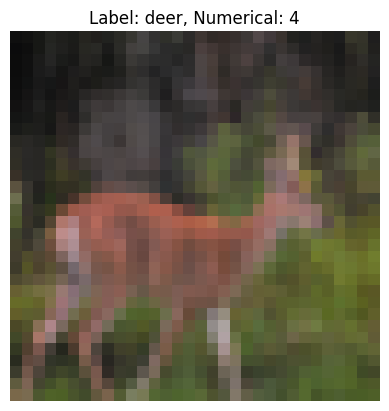

In [10]:
# Convert the image tensor to a NumPy array and transpose to (32, 32, 3) for plotting
image_np = image.cpu().permute(1, 2, 0).numpy()

# The images were normalised for the "intended use", so we need to un-normalise them for plotting
image_np = image_np * 255.0

# Display the image with its label
plt.imshow(image_np.astype("uint8"))
plt.title(f"Label: {cifar10_classes[label]}, Numerical: {label}")
plt.axis('off')
plt.show()

In [11]:
class Result():
    def __init__(self):
        self.best_val_accuracy = 0 # So we can tell if the new model gets better
        self.best_pred = None # holds the best prediction to plot the model graph later
        self.epochs_used = 0 # How many epochs were used to train the model

        self.train_loss_history = []
        self.recall_history = []
        self.precision_history = []

        # Early stopping proposal is to check in each EPOCH how good the model is with the validation set
        # If the validation performs better than any previous Epoch then make the current model the best model and set the patience_counter = 0
        # If the validation performs worse than than the best model then increase the patience_counter by +1
        # If the patience_counter exceeds the patience threshhold then stop training and use the best model found with the test data set
        self.patience, self.patience_counter = 5, 0 # If the model doesn't improve relative to the best model then stop after this main epochs without improvement



In [12]:
class Experiment():
    def __init__(self, model, optimizer=None, scheduler=None, criterion=None):
        self.model = model
        self.model_name = model.__class__.__name__
        self.model_params = model.get_init_params()
        if (optimizer == None):
            self.optimizer = self.create_optimizer()
        else:
            self.optimizer = optimizer
        if (scheduler == None):
            self.scheduler = self.create_scheduler()
        else:
            self.scheduler = scheduler
        if (criterion == None):
            self.criterion = nn.CrossEntropyLoss()
        else:
            self.criterion = criterion
        self.result = Result()

    def create_optimizer(self):
        # Use ADAM as an optimizer as it seemed to perform pretty well last time
        # Maybe compare with other optimizers...
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def create_scheduler(self):
        # What is the best learning rate?
        # scheduler: This is the learning rate scheduler object that you can use to adjust the learning rate during each epoch or training step.
        # torch.optim.lr_scheduler.CosineAnnealingLR: This is a specific type of learning rate scheduler in PyTorch that decreases the learning rate following a cosine curve.
        # optimizer: This is the optimizer that the learning rate scheduler will modify. The optimizer manages the parameters and updates them based on the learning rate.
        # T_max=10: This parameter specifies the maximum number of iterations (or epochs) before the learning rate reaches its minimum value. In this case, T_max=10 means that over the course of 10 epochs, the learning rate will decrease following a cosine curve until it reaches the minimum.
        return torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10, eta_min=1e-6)
    
    def free_memory(self):
        # Free up memory
        del self.model
        del self.optimizer
        del self.scheduler
        del self.criterion
        # del self.result // we keep the result for later use

# 3. When training - calculate loss etc on both (train and valid) and decide on training success based on validation set

In [13]:
# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    model_pred = None
    for X, y in dataloader: # X is the data and y the label
        X, y = X.to(device), y.to(device) # device is either CPU or GPU

        optimizer.zero_grad() # We don't want the previous gradients to contaminate the optimizer so we reset them
        model_pred = model(X) # data is passed through the model to generate a prediction of the label
        loss = loss_fn(model_pred, y) # loss_fn uses the "cross entropy" model mentioned in class to compare the predicted label (pred) with the actual lable (y). A low value is good
        # Backpropagation: Back propagation is attempting to figure out which of the weights are responsible for most of the error. It does this by calculating the error between the predicted output and actual output and then propagating this error back through the layers to find out how much each weight contributed to the error. Like tuning a radio, the learning rate comes in here and is related to how big a click the weight knob can be turned in one step up or down in order that the overall error can be reduced.
        loss.backward() # Calculate the gradients of the loss
        optimizer.step() # Tune the radio to reduce the error using Adam to estimate how much to tune it by

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss, model_pred

# Validation loop: this can be used for both the validation data during the training and the test data after the best model has been found
def validate_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss, correct = 0, 0
    pred = None
    recall = None
    true_positives = 0
    false_negatives = 0
    false_positives = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            y_pred = (pred.argmax(1) == 1).float()
            true_positives += ((y_pred == 1) & (y == 1)).sum().item()
            false_negatives += ((y_pred == 0) & (y == 1)).sum().item()
            false_positives += ((y_pred == 1) & (y == 0)).sum().item()

            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    recall = true_positives / (true_positives + false_negatives)
    precision = 0
    if (true_positives + false_positives) > 0:
        precision = true_positives / (true_positives + false_positives)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy, pred, recall, precision

## 4. Implement your own early stopping: i.e. if validation loss has not decreased over n (to be defined, e.g. 10 or 20) iterations (delta to be defined, e.g. 10^(-4)), training is stopped and the last model is saved - please find out for yourself how to save a torch model

In [14]:
class model_exec_loop():
    def __init__(self, i, experiment):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device)) # Shuffle training set. Because of shuffle, we need to set the genrator set to the actual device
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False) # Don't shuffle validation set
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) # Don't shuffle the test set
        self.experiment = experiment

        print(f"Training model {experiment.model.__class__.__name__}_{experiment.model.get_init_params()} with hidden sizes {experiment.model.get_init_params()} \n")
        # Loop training "epochs" number of times
        for t in range(epochs):
            print(f"Epoch {t+1} for {i}\n-------------------------------")
            # Run the training from task 3
            train_loss, model_pred = train_loop(train_loader, experiment.model, experiment.loss_fn, experiment.optimizer)
            self.experiment.result.train_loss_history.append(train_loss)
            # After each attempt at training test the model against the validation set
            val_loss, val_accuracy, pred, recall, precision = validate_loop(val_loader, experiment.model, experiment.loss_fn)
            self.experiment.result.recall_history.append(recall)
            self.experiment.result.precision_history.append(precision)
            print(f"{i} Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {(100*val_accuracy):>0.1f}%, Recall: {recall}, Precision: {precision}")

            # Check for improvement and if better than before, write out the model to disk
            if val_accuracy > self.experiment.result.best_val_accuracy: # New model is better than the old model
                self.experiment.result.best_val_accuracy = val_accuracy
                self.experiment.result.best_pred = model_pred
                torch.save(experiment.model.state_dict(), f"best_model_{i}.pth")
                self.experiment.result.patience_counter = 0 # I am interested again, reset my boredom levels
                print(f"Best model saved for {i}.")
            else:
                # If the model is worse then increase the patience_counter until we give up
                self.experiment.result.patience_counter += 1 # Computer gets slightly more bored when the new model is less good than the best so far
                if self.experiment.result.patience_counter >= self.experiment.result.patience: # Boredom threshhold is past so the computer gives up as the model isn't improving
                    print(f"Early stopping triggered for {i}. Training stopped. \n")
                    break

            # Adjust learning rate
            experiment.scheduler.step() # Slightly unclear how this actually works
            print(f"Learning Rate for {i}: {experiment.scheduler.get_last_lr()[0]} \n")

        # Load the best model for testing
        experiment.model.load_state_dict(torch.load(f"best_model_{i}.pth", weights_only=True))
        print("Testing on the test dataset with the best model:")
        test_loss, test_accuracy, pred, recall, precision = validate_loop(test_loader, experiment.model, experiment.loss_fn)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {(100*test_accuracy):>0.1f}%, Recall: {recall}, Precision: {precision}")
        print("****************************")

In [15]:
class cnn_exec_loop():
    def __init__(self, i, experiment):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device)) # Shuffle training set. Because of shuffle, we need to set the genrator set to the actual device
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False) # Don't shuffle validation set
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) # Don't shuffle the test set
        self.experiment = experiment

        print(f"Training model {experiment.model.get_init_params()} \n")
        # Loop training "epochs" number of times
        for t in range(epochs):
            print(f"Epoch {t+1} for {i}\n-------------------------------")
            # Run the training from task 3
            train_loss, model_pred = train_loop(train_loader, experiment.model, experiment.loss_fn, experiment.optimizer)
            self.experiment.result.train_loss_history.append(train_loss)
            # After each attempt at training test the model against the validation set
            val_loss, val_accuracy, pred, recall, precision = validate_loop(val_loader, experiment.model, experiment.loss_fn)
            self.experiment.result.recall_history.append(recall)
            self.experiment.result.precision_history.append(precision)
            print(f"{i} Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {(100*val_accuracy):>0.1f}%, Recall: {recall}, Precision: {precision}")

            # Check for improvement and if better than before, write out the model to disk
            if val_accuracy > self.experiment.result.best_val_accuracy: # New model is better than the old model
                self.experiment.result.best_val_accuracy = val_accuracy
                self.experiment.result.best_pred = model_pred
                torch.save(experiment.model.state_dict(), f"best_model_{i}.pth")
                self.experiment.result.patience_counter = 0 # I am interested again, reset my boredom levels
                print(f"Best model saved for {i}.")
            else:
                # If the model is worse then increase the patience_counter until we give up
                self.experiment.result.patience_counter += 1 # Computer gets slightly more bored when the new model is less good than the best so far
                if self.experiment.result.patience_counter >= self.experiment.result.patience: # Boredom threshhold is past so the computer gives up as the model isn't improving
                    print(f"Early stopping triggered for {i}. Training stopped. \n")
                    break

            # Adjust learning rate
            experiment.scheduler.step() # Slightly unclear how this actually works
            print(f"Learning Rate for {i}: {experiment.scheduler.get_last_lr()[0]} \n")

        # Load the best model for testing
        experiment.model.load_state_dict(torch.load(f"best_model_{i}.pth", weights_only=True))
        print("Testing on the test dataset with the best model:")
        test_loss, test_accuracy, pred, recall, precision = validate_loop(test_loader, experiment.model, experiment.loss_fn)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {(100*test_accuracy):>0.1f}%, Recall: {recall}, Precision: {precision}")
        print("****************************")

In [16]:
import psutil
class rnn_exec_loop():
    def __init__(self, j, experiment):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device)) # Shuffle training set. Because of shuffle, we need to set the genrator set to the actual device
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False) # Don't shuffle validation set
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) # Don't shuffle the test set
        self.experiment = experiment

        

        print(f"Training model {experiment.model.__class__.__name__}_{experiment.model.get_init_params()} with hidden sizes {experiment.model.get_init_params()} \n")
        # Number of steps to unroll
        seq_dim = experiment.model.input_dim * 3 # (3 channels because of the colors)

        iter = 0
        for epoch in range(epochs):
            print(f"Epoch {epoch+1} for {j}\n-------------------------------")
            print(f"Memory used: {psutil.virtual_memory().percent}%")
            for i, (images, labels) in enumerate(train_loader):
                experiment.model.train()
                # Load images as tensors with gradient accumulation abilities
                images = images.reshape(-1, seq_dim, experiment.model.input_dim).requires_grad_()
                #images = images.permute(0, 2, 3, 1).reshape(-1, seq_dim, experiment.model.input_dim).requires_grad_().to(device)

                # Clear gradients w.r.t. parameters
                experiment.optimizer.zero_grad()

                # Forward pass to get output/logits
                # outputs.size() --> 100, 10
                outputs = experiment.model(images)

                # Calculate Loss: softmax --> cross entropy loss
                loss = experiment.criterion(outputs, labels)
                self.experiment.result.train_loss_history.append(loss)

                # Getting gradients w.r.t. parameters
                loss.backward()

                # Updating parameters
                experiment.optimizer.step()

                iter += 1
                early_stopping = False

                if iter % 500 == 0:
                    experiment.model.eval()
                    # Calculate Accuracy
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for images, labels in test_loader:
                        # Load images to a Torch tensors with gradient accumulation abilities
                        images = images.reshape(-1, seq_dim, experiment.model.input_dim)

                        # Forward pass only to get logits/output
                        outputs = experiment.model(images)

                        # Get predictions from the maximum value
                        _, predicted = torch.max(outputs.data, 1)

                        # Total number of labels
                        total += labels.size(0)

                        # Total correct predictions
                        correct += (predicted == labels).sum()

                    val_accuracy = 100 * correct / total
                    if val_accuracy > self.experiment.result.best_val_accuracy: # New model is better than the old model
                        self.experiment.result.best_val_accuracy = val_accuracy
                        self.experiment.result.best_pred = predicted  # todo: is this correct?
                        torch.save(experiment.model.state_dict(), f"best_model_{j}.pth")
                        self.experiment.result.patience_counter = 0 # I am interested again, reset my boredom levels
                        print(f"Best model saved for {j}.")
                    else:
                        # If the model is worse then increase the patience_counter until we give up
                        self.experiment.result.patience_counter += 1 # Computer gets slightly more bored when the new model is less good than the best so far
                        if self.experiment.result.patience_counter >= self.experiment.result.patience: # Boredom threshhold is past so the computer gives up as the model isn't improving
                            print(f"Early stopping triggered for {j}. Training stopped. \n")
                            early_stopping = True
                    
                    # Print Loss
                    print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), val_accuracy))

                if early_stopping:
                    break

# RNN Experiments

## Model A: 1 Hidden Layer (ReLU)
- Unroll 32 time steps
    - Each step input size: 32 x 1
    - Total per unroll: 32 x 32*3
        - Feedforward Neural Network input size: 32 x 32*3
- 1 Hidden layer
- ReLU Activation Function

<img src="https://drive.google.com/uc?export=view&id=1GDaMOh5TXnvr8W8xfdghXbbSEyI6M4b1" width="900">

In [17]:
# Model A: 1 Hidden Layer ReLU
class RNNModel_1HiddenLayer_ReLU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel_1HiddenLayer_ReLU, self).__init__()
        
        # Number of input dim
        self.input_dim = input_dim
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Number of output dimensions
        self.output_dim = output_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu') #

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 10
        # out[:, -1, :] --> 100, 10 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out
    
    def get_init_params(self):
        return f'input_dim={self.input_dim}, hidden_dim={self.hidden_dim}, layer_dim={self.layer_dim}, output_dim={self.output_dim}'


In [18]:
force_rnn_experiment = True # Set to True to force the training of the models again, set to false to skip if already computed
if force_rnn_experiment == True:
    rnn_experiments = [] # Reset the experiments

In [19]:
rnn_models = []

# Define the models
rnn_models.append(RNNModel_1HiddenLayer_ReLU(input_dim=32, hidden_dim=100, layer_dim=1, output_dim=10))
rnn_models.append(RNNModel_1HiddenLayer_ReLU(input_dim=32, hidden_dim=100, layer_dim=2, output_dim=10))
rnn_models.append(RNNModel_1HiddenLayer_ReLU(input_dim=32, hidden_dim=50, layer_dim=1, output_dim=10))
rnn_models.append(RNNModel_1HiddenLayer_ReLU(input_dim=32, hidden_dim=200, layer_dim=1, output_dim=10))


if len(rnn_experiments) == 0:
    for model in rnn_models:
        experiment = Experiment(model)
        rnn_experiments.append(experiment)
        rnn_exec_loop(len(rnn_experiments), experiment)
        experiment.free_memory()
        
print("All models trained")

Training model RNNModel_1HiddenLayer_ReLU_input_dim=32, hidden_dim=100, layer_dim=1, output_dim=10 with hidden sizes input_dim=32, hidden_dim=100, layer_dim=1, output_dim=10 

Epoch 1 for 1
-------------------------------
Memory used: 37.4%
Best model saved for 1.
Iteration: 500. Loss: 2.131485939025879. Accuracy: 19.559999465942383
Best model saved for 1.
Iteration: 1000. Loss: 2.1129095554351807. Accuracy: 21.030000686645508
Best model saved for 1.
Iteration: 1500. Loss: 2.2409284114837646. Accuracy: 22.020000457763672
Epoch 2 for 1
-------------------------------
Memory used: 42.9%
Iteration: 2000. Loss: 2.205427408218384. Accuracy: 19.540000915527344
Best model saved for 1.
Iteration: 2500. Loss: 1.987099528312683. Accuracy: 22.540000915527344
Best model saved for 1.
Iteration: 3000. Loss: 1.8214974403381348. Accuracy: 22.559999465942383
Best model saved for 1.
Iteration: 3500. Loss: 1.9987901449203491. Accuracy: 26.579999923706055
Epoch 3 for 1
-------------------------------
Memo

In [20]:
from tabulate import tabulate

#experiments = linear_experiments + conv2d_experiments
experiments = rnn_experiments

# Print the results
print("Results")
table = [['Row','Model', 'Best Validation Accuracy', 'Recall', 'Precision', 'Epochs']]
for i, experiment in enumerate(experiments):
    best_val_accuracy = experiment.result.best_val_accuracy
    #recall = experiment.result.recall_history[-1]
    recall = 'N/A'
    #precision = experiment.result.precision_history[-1]
    precision = 'N/A'
    epochs_used = len(experiment.result.train_loss_history)
    table.append([i, f"{experiment.model.__class__.__name__}_{experiment.model.get_init_params()}", f"{best_val_accuracy:.2f}%", recall, precision, epochs_used])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Results


AttributeError: 'Experiment' object has no attribute 'model'